# Проект: Обучение с учителем: качество модели

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.
    
Требуется разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Описание данных

Данные для работы находятся в нескольких таблицах.

**market_file.csv** - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* **id** — номер покупателя в корпоративной базе данных.
* **Покупательская активность** — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* **Тип сервиса** — уровень сервиса, например «премиум» и «стандарт».
* **Разрешить сообщать** — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* **Маркет_актив_6_мес** — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* **Маркет_актив_тек_мес** — количество маркетинговых коммуникаций в текущем месяце.
* **Длительность** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* **Акционные_покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* **Популярная_категория** — самая популярная категория товаров у покупателя за последние 6 месяцев.
* **Средний_просмотр_категорий_за_визит** — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* **Неоплаченные_продукты_штук_квартал** — общее число неоплаченных товаров в корзине за последние 3 месяца.
* **Ошибка_сервиса** — число сбоев, которые коснулись покупателя во время посещения сайта.
* **Страниц_за_визит** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_money.csv** - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* **id** — номер покупателя в корпоративной базе данных.
* **Период** — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* **Выручка** — сумма выручки за период.

**market_time.csv** - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* **id** — номер покупателя в корпоративной базе данных.
* **Период** — название периода, во время которого зафиксировано общее время.
* **минут** — значение времени, проведённого на сайте, в минутах.

**money.csv** - таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* **id** — номер покупателя в корпоративной базе данных.
* **Прибыль** — значение прибыли.

## Шаг 1. Загрузка данных

### 1.1 Загружаем данные

In [1]:
!pip install shap
!pip install phik
!pip install -Uq scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from phik.report import plot_correlation_matrix
from phik import report

In [2]:
try:
    behavior = pd.read_csv("D:\Practicum\DS 47+\project\ML_teacher\market_file.csv")
    revenue = pd.read_csv("D:\Practicum\DS 47+\project\ML_teacher\market_money.csv")
    time = pd.read_csv("D:\Practicum\DS 47+\project\ML_teacher\market_time.csv")
    profit = pd.read_csv("D:\Practicum\DS 47+\project\ML_teacher\money.csv", sep = ';')
except:
    behavior = pd.read_csv("/datasets/market_file.csv")
    revenue = pd.read_csv("/datasets/market_money.csv")
    time = pd.read_csv("/datasets/market_time.csv")
    profit = pd.read_csv("/datasets/money.csv", sep = ';')

In [3]:
behavior.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
revenue.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
profit.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


### 1.2 Проверим, данные в таблицах на соответствие описанию

In [7]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


в датасэте **money** в столбце **Прибыль** не совсем понятны единицы отображения значений, а так же их тип - **object**

## Шаг 2. Предобработка данных

### Переименование столбцов

In [11]:
#переименуем столбцы
behavior = behavior.rename(
    columns={"Покупательская активность":"buyer_activity",
             "Тип сервиса":"service_type",
             "Разрешить сообщать":"message_access",
             "Маркет_актив_6_мес":"market_active_6m",
             "Маркет_актив_тек_мес":"market_active_current_m",
             "Длительность":"duration",
             "Акционные_покупки":"sale_buy",
             "Популярная_категория":"pop_cat",
             "Средний_просмотр_категорий_за_визит":"mean_view_cat_per_visit",
             "Неоплаченные_продукты_штук_квартал":"non_buy_prod_per_quarter",
             "Ошибка_сервиса":"service_error",
             "Страниц_за_визит":"page_per_visit"
    }
)
#behavior.head()

In [12]:
revenue = revenue.rename(
    columns={
        "Период":"period",
        "Выручка":"revenue"
    }
)
#revenue.head()

In [13]:
time = time.rename(
    columns={
        "Период":"period",
        "минут":"minutes"
    }
)
#time.head()

In [14]:
profit = profit.rename(
    columns={
        "Прибыль":"profit"      
    }
)
#profit.head()

### Поиск пропущенных значений

In [15]:
behavior.isna().sum()

id                          0
buyer_activity              0
service_type                0
message_access              0
market_active_6m            0
market_active_current_m     0
duration                    0
sale_buy                    0
pop_cat                     0
mean_view_cat_per_visit     0
non_buy_prod_per_quarter    0
service_error               0
page_per_visit              0
dtype: int64

In [16]:
revenue.isna().sum()

id         0
period     0
revenue    0
dtype: int64

In [17]:
time.isna().sum()

id         0
period     0
minutes    0
dtype: int64

In [18]:
profit.isna().sum()

id        0
profit    0
dtype: int64

### Поиск дубликатов

In [19]:
behavior.duplicated().sum()

0

In [20]:
revenue.duplicated().sum()

0

In [21]:
time.duplicated().sum()

0

In [22]:
profit.duplicated().sum()

0

### Поиск неявных дубликатов

In [23]:
behavior['buyer_activity'].value_counts()

Прежний уровень    802
Снизилась          498
Name: buyer_activity, dtype: int64

In [24]:
behavior['buyer_activity'] = behavior['buyer_activity'].str.lower().replace('прежний уровень', 'прежний_уровень')

In [25]:
behavior['buyer_activity'].value_counts()

прежний_уровень    802
снизилась          498
Name: buyer_activity, dtype: int64

In [26]:
behavior['service_type'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: service_type, dtype: int64

In [27]:
behavior['service_type'] = behavior['service_type'].replace('стандартт','стандарт')

In [28]:
behavior['service_type'].value_counts()

стандарт    924
премиум     376
Name: service_type, dtype: int64

In [29]:
behavior['message_access'].value_counts()

да     962
нет    338
Name: message_access, dtype: int64

In [30]:
behavior['pop_cat'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: pop_cat, dtype: int64

In [31]:
behavior['pop_cat'] = behavior['pop_cat'].replace(
    ["Товары для детей", 
     "Домашний текстиль", 
     "Косметика и аксесуары", 
     "Техника для красоты и здоровья", 
     "Мелкая бытовая техника и электроника", 
     "Кухонная посуда"],
    ["товары_для_детей", 
     "домашний_текстиль", 
     "косметика_и_аксесуары", 
     "техника_для_красоты_и_здоровья", 
     "мелкая_бытовая_техника_и_электроника", 
     "кухонная_посуда"]
)

In [32]:
behavior['pop_cat'].value_counts()

товары_для_детей                        330
домашний_текстиль                       251
косметика_и_аксесуары                   223
техника_для_красоты_и_здоровья          184
мелкая_бытовая_техника_и_электроника    174
кухонная_посуда                         138
Name: pop_cat, dtype: int64

In [33]:
revenue['period'].value_counts()

текущий_месяц          1300
предыдущий_месяц       1300
препредыдущий_месяц    1300
Name: period, dtype: int64

In [34]:
#revenue['period'] =  revenue['period'].replace('препредыдущий_месяц','предыдущий_месяц')

In [35]:
#revenue['period'].value_counts()

In [36]:
time['period'].value_counts()

текущий_месяц       1300
предыдцщий_месяц    1300
Name: period, dtype: int64

In [37]:
time['period'] =  time['period'].replace('предыдцщий_месяц','предыдущий_месяц')

In [38]:
time['period'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: period, dtype: int64

In [39]:
behavior.head()

,id,buyer_activity,service_type,message_access,market_active_6m,market_active_current_m,duration,sale_buy,pop_cat,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


In [40]:
revenue.head()

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [41]:
time.head()

,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [42]:
profit.head()

,id,profit
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [43]:
#заменяем разделитель ',' на '.', а так же тип данных
profit['profit'] = profit['profit'].str.replace(',','.').astype('float64')

In [44]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [45]:
behavior.duplicated().sum()

0

In [46]:
revenue.duplicated().sum()

0

In [47]:
revenue.shape

(3900, 3)

In [48]:
revenue = revenue.drop_duplicates().reset_index(drop=True)

In [49]:
revenue.shape

(3900, 3)

In [50]:
time.duplicated().sum()

0

In [51]:
profit.duplicated().sum()

0

**Вывод по предобработке данных**

На этапе предобработки мы переименовали столбцы,выполнили поиск пропусков и дубликатов. Так же избавились от неявных дубликатов и изменили тип данных и разделитель в столбце 'profit' датасэта profit

## Шаг 3. Исследовательский анализ данных

In [52]:
behavior.describe()

,id,market_active_6m,market_active_current_m,duration,sale_buy,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


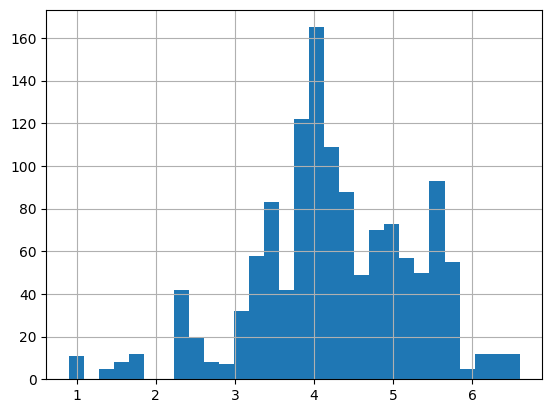

In [53]:
behavior['market_active_6m'].hist(bins=30)
plt.show()

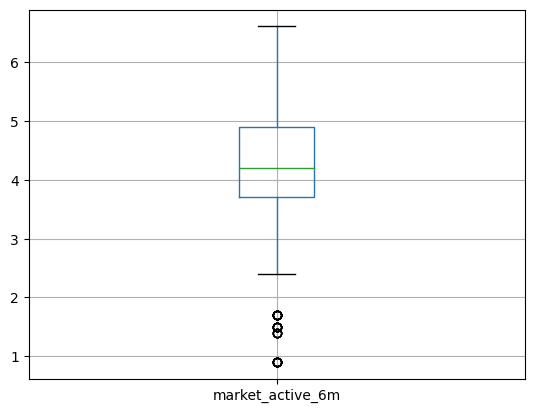

In [54]:
behavior.boxplot('market_active_6m')
plt.show()

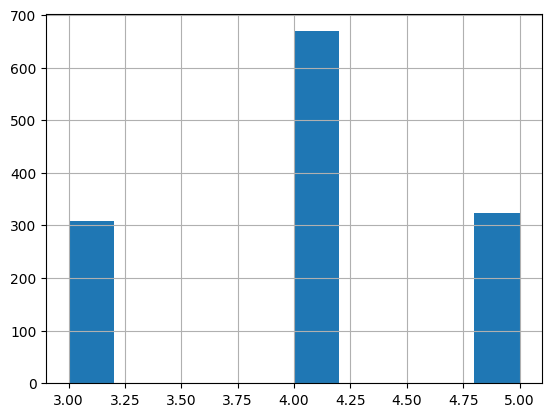

In [55]:
behavior['market_active_current_m'].hist(bins=10)
plt.show()

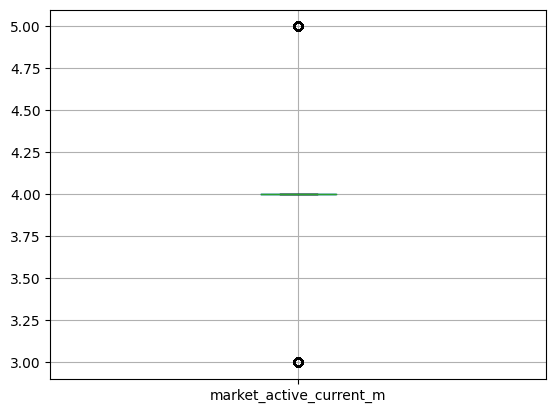

In [56]:
behavior.boxplot('market_active_current_m')
plt.show()

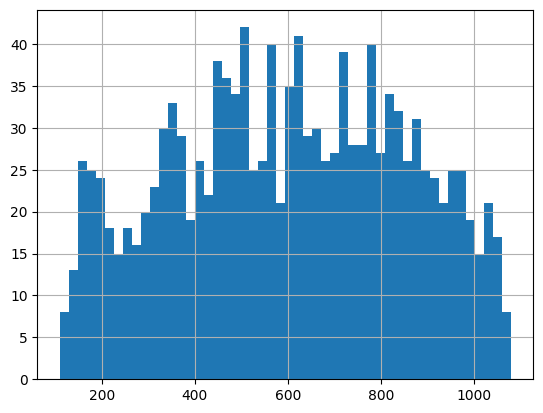

In [57]:
behavior['duration'].hist(bins=50)
plt.show()

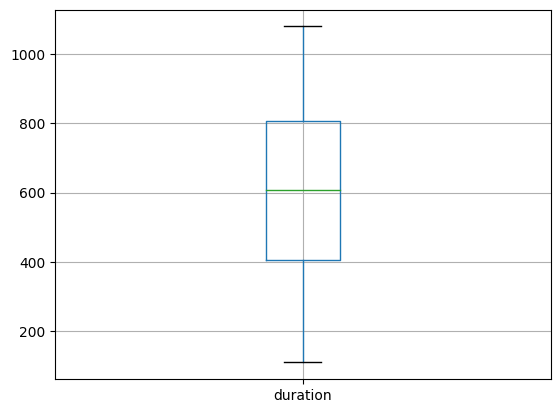

In [58]:
behavior.boxplot('duration')
plt.show()

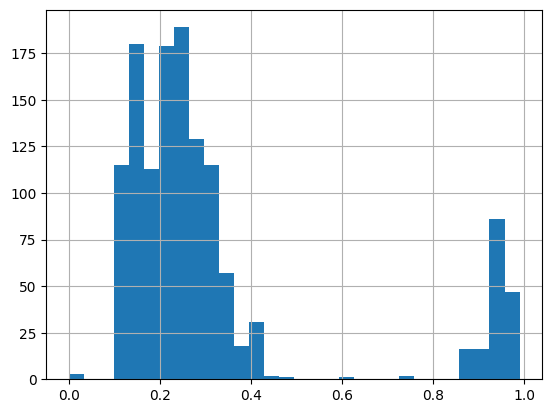

In [59]:
behavior['sale_buy'].hist(bins=30)
plt.show()

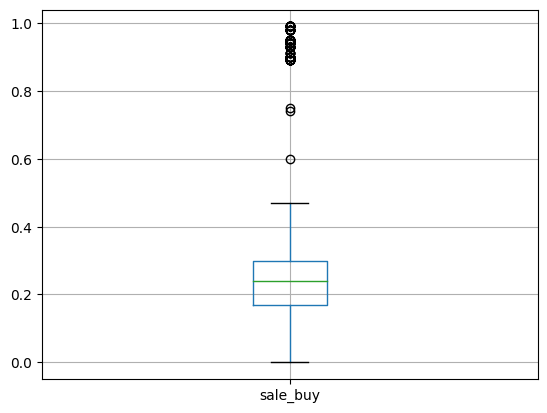

In [60]:
behavior.boxplot('sale_buy')
plt.show()

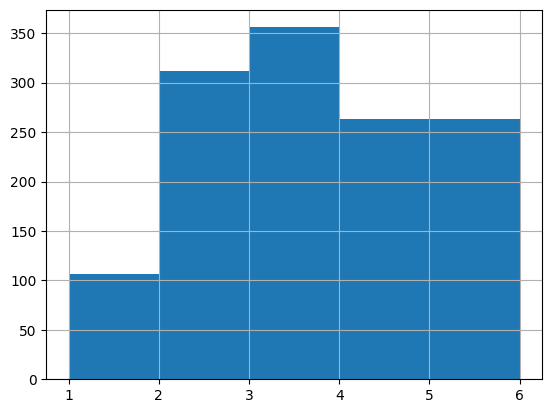

In [61]:
behavior['mean_view_cat_per_visit'].hist(bins=5)
plt.show()

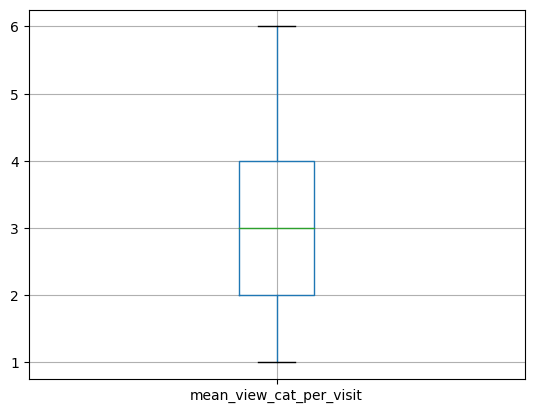

In [62]:
behavior.boxplot('mean_view_cat_per_visit')
plt.show()

In [63]:
revenue.describe()

,id,revenue
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


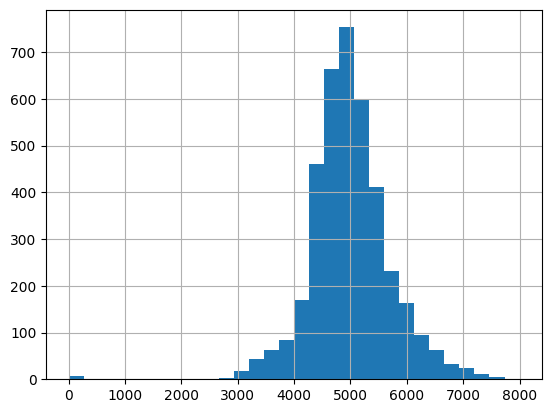

In [64]:
revenue['revenue'].hist(bins=30, range=(0,8000))
plt.show()

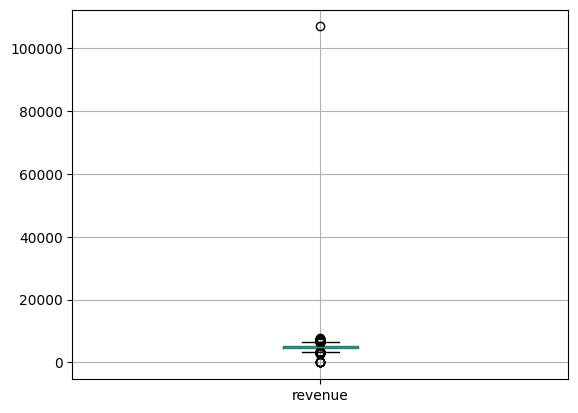

In [65]:
revenue.boxplot('revenue')
plt.show()

По диаграмме размаха наблюдается вылет значений в районе 100 000. Необходимо подробнее взглянуть на данные в этом диапазоне

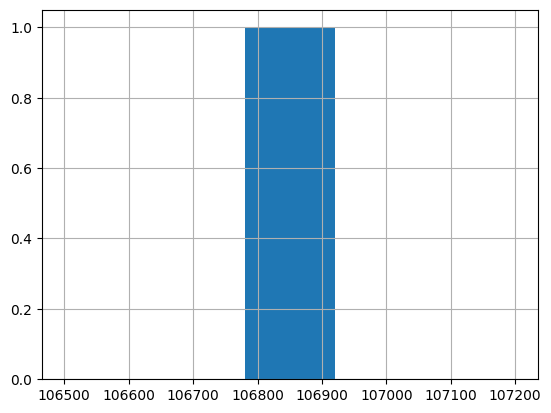

In [66]:
revenue['revenue'].hist(bins=5, range=(106500,107200))
plt.show()

In [67]:
print(revenue[revenue['revenue'] > 70000])

        id         period   revenue
98  215380  текущий_месяц  106862.2


Вот строка с вылетом. Необходимо ее удалить

In [68]:
revenue.shape

(3900, 3)

In [69]:
revenue = revenue[revenue['revenue']<70000]
revenue.shape

(3899, 3)

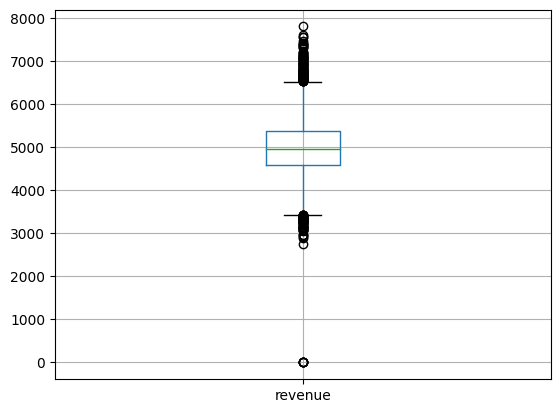

In [70]:
revenue.boxplot('revenue')
plt.show()

In [71]:
print(revenue[revenue['revenue'] < 2000])

        id               period  revenue
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0


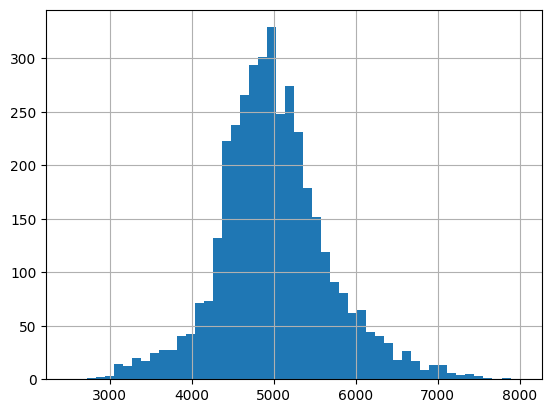

In [72]:
revenue['revenue'].hist(bins=50, range=(2500,8000))
plt.show()

In [73]:
time.describe()

,id,minutes
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


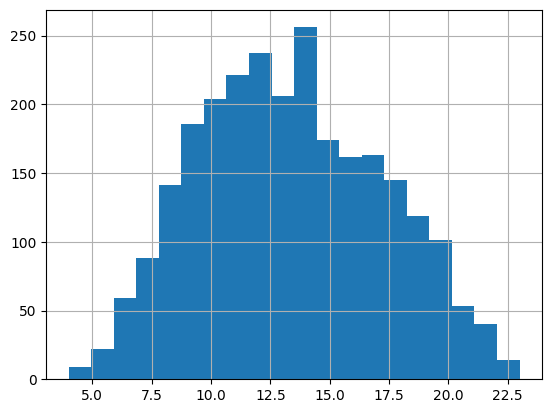

In [74]:
time['minutes'].hist(bins=20)
plt.show()

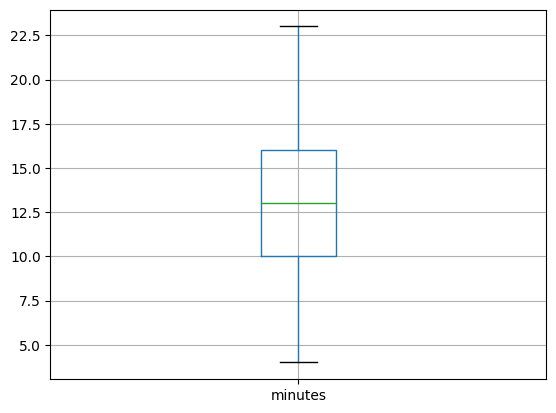

In [75]:
time.boxplot('minutes')
plt.show()

In [76]:
profit.describe()

,id,profit
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


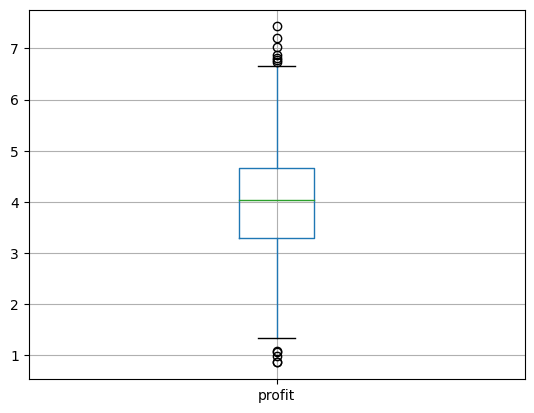

In [77]:
profit.boxplot('profit')
plt.show()

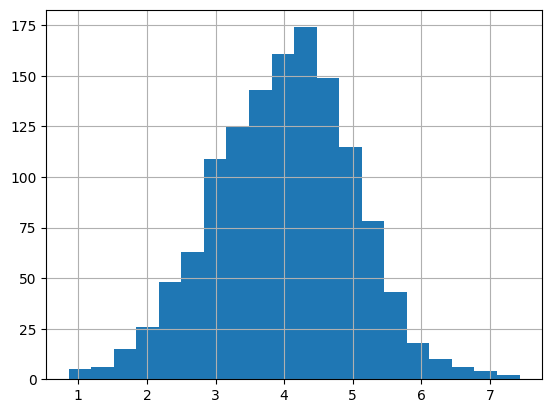

In [78]:
profit['profit'].hist(bins=20)
plt.show()

In [79]:
revenue_zero = revenue[revenue['revenue'] == 0]
revenue_zero.head()

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0


Видим 3 пользователя (ID = 215348, 215357, 215359), которые не подходят под наши условия о покупательской активности не менее 3х месяцев. Необходимо удалить их из нашего датасэта

In [80]:
revenue.shape

(3899, 3)

In [81]:
revenue_3m = revenue.query('id != (215348, 215357, 215359)')
revenue_3m.head()

,id,period,revenue
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


## Шаг 4. Объединение таблиц

### 4.1 Объединяем таблицы market_file.csv, market_money.csv, market_time.csv. 

In [82]:
revenue_pivot = revenue_3m.pivot_table(
    index = 'id',
    columns = 'period',
    values = 'revenue',
    aggfunc = 'sum'
)
revenue_pivot.head()

period,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [83]:
#проверим созданную таблицу на пропуски
revenue_pivot[revenue_pivot['текущий_месяц'].isna()]

period,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215380,6077.0,5051.0,NaN


In [84]:
#проверим данные по пользователю '215380' в исходном датафреймне
revenue_3m.query('id == 215380')

,id,period,revenue
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0


Данные за текущи месяц у пользователя с id 215380 отсутствуют, значит он не подходит под заданные ранее условия о покупательской активности не менее 3х месяцев. Необходимо исключить пользователя из дальнейшего исследования

In [85]:
revenue_pivot.shape

(1297, 3)

In [86]:
revenue_pivot = revenue_pivot.query('id != 215380')
revenue_pivot.shape

(1296, 3)

In [87]:
time_pivot = time.pivot_table(
    index = 'id',
    columns = 'period',
    values = 'minutes',
    aggfunc = 'sum'
)
time_pivot.head()

period,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [88]:
market = revenue_pivot.merge(time_pivot, on='id')
market.head()

period,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
id,,,,,
215349,5216.0,4472.0,4971.6,12,10
215350,5457.5,4826.0,5058.4,8,13
215351,6158.0,4793.0,6610.4,11,13
215352,5807.5,4594.0,5872.5,8,11
215353,4738.5,5124.0,5388.5,10,10


In [89]:
market = market.merge(behavior,on='id')
market.head()

,id,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y,buyer_activity,service_type,message_access,market_active_6m,market_active_current_m,duration,sale_buy,pop_cat,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit
0,215349,5216.0,4472.0,4971.6,12,10,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
1,215350,5457.5,4826.0,5058.4,8,13,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
2,215351,6158.0,4793.0,6610.4,11,13,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
3,215352,5807.5,4594.0,5872.5,8,11,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2
4,215353,4738.5,5124.0,5388.5,10,10,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4


In [90]:
#market.info()

In [91]:
market = market.rename(columns={
    'предыдущий_месяц_x':'revenue_previous_month',
    'препредыдущий_месяц':'revenue_month_before_last',
    'текущий_месяц_x':'revenue_current_month',
    'предыдущий_месяц_y':'time_previous_month',
    'текущий_месяц_y':'time_current_month'
}
                      )

In [92]:
market.head()

,id,revenue_previous_month,revenue_month_before_last,revenue_current_month,time_previous_month,time_current_month,buyer_activity,service_type,message_access,market_active_6m,market_active_current_m,duration,sale_buy,pop_cat,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit
0,215349,5216.0,4472.0,4971.6,12,10,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
1,215350,5457.5,4826.0,5058.4,8,13,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
2,215351,6158.0,4793.0,6610.4,11,13,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
3,215352,5807.5,4594.0,5872.5,8,11,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2
4,215353,4738.5,5124.0,5388.5,10,10,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4


**Вывод:**

 На этом этапе мы объединили таблицы. Так же удалили данные о пользователе "id 215380", так как у него был вылет в данных за текущий месяц.

## Шаг 5. Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования

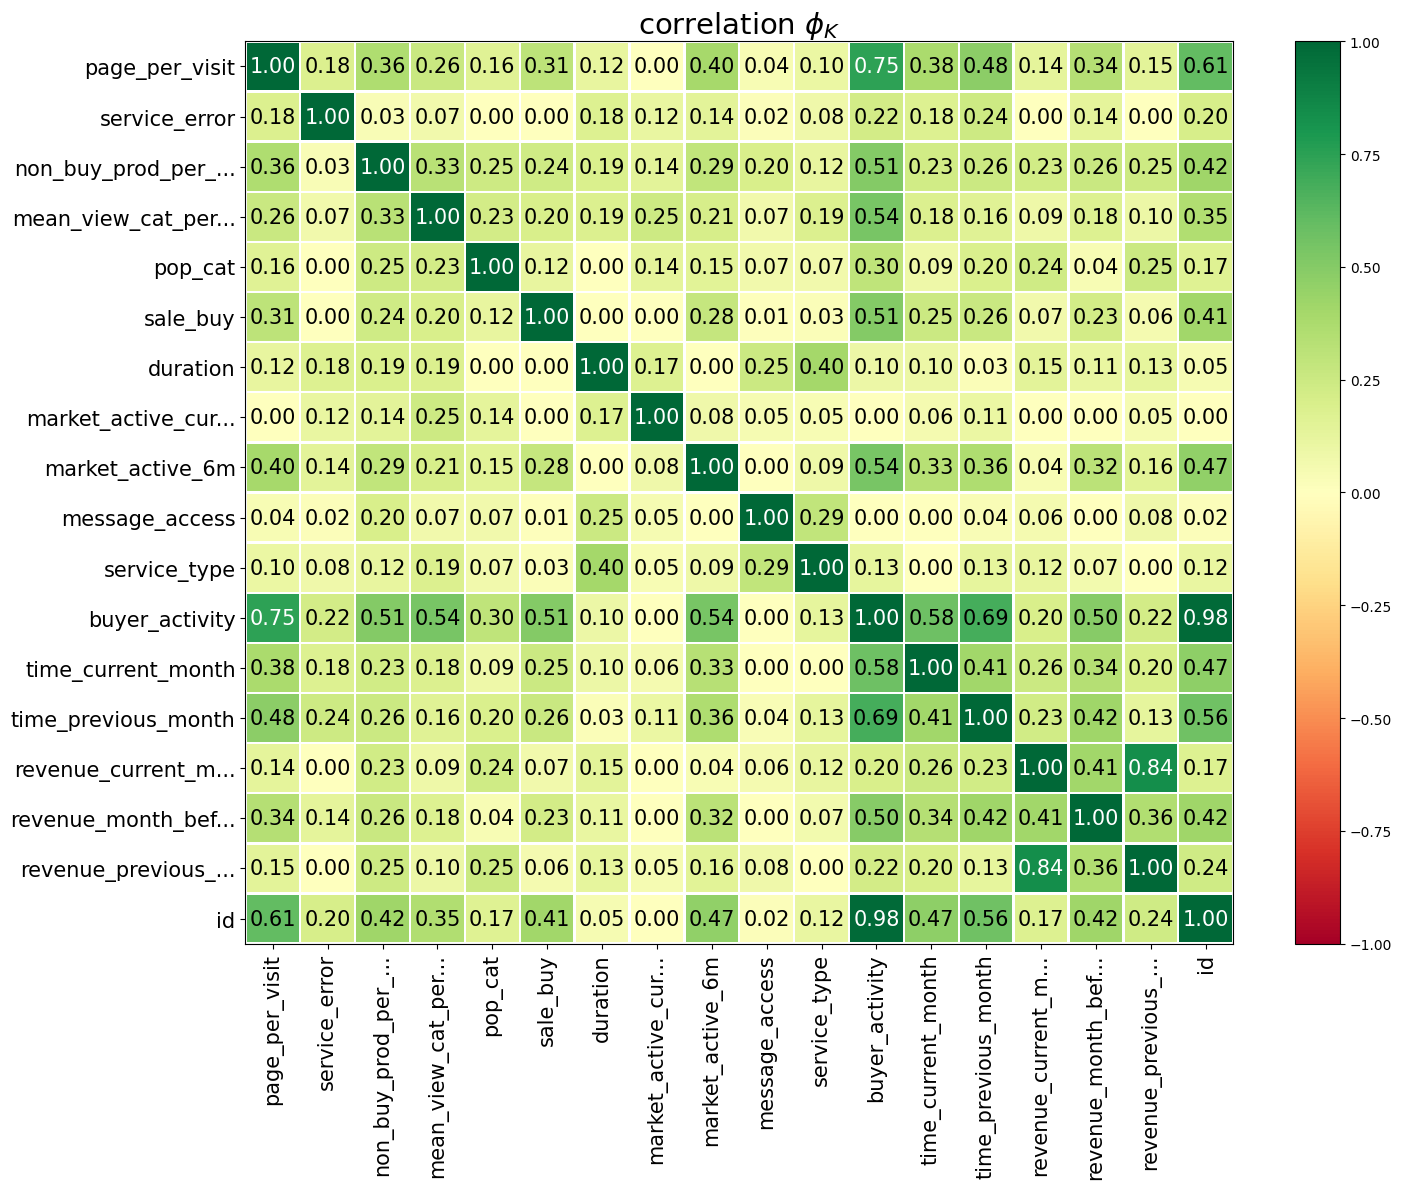

In [93]:
#sns.set(rc={"figure.figsize": (15, 8)})
#sns.heatmap(market.corr(), annot=True, cmap='cividis');

# список интервальных признаков
interval_cols = ['id', 
                 'revenue_previous_month', 
                 'revenue_month_before_last', 
                 'revenue_current_month', 
                 'time_previous_month', 
                 'time_current_month', 
                 'market_active_6m', 
                 'market_active_current_m', 
                 'duration', 
                 'sale_buy', 
                 'mean_view_cat_per_visit', 
                 'non_buy_prod_per_quarter', 
                 'service_error', 
                 'page_per_visit']

# вычисление коэффициентов корреляции phi
phik_overview = market.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Определение коэффициента phik показало, что между активностью покупателей и id прослеживается линейная зависимость. Попробуем удалить столбей с id

In [94]:
#market['revenue_2m'] = market['revenue_current_month'] + market['revenue_previous_month']
#market_v2 = market.drop(['revenue_current_month','revenue_previous_month'], axis=1)

market_v2 = market.drop('id', axis=1)
market_v2.head()

,revenue_previous_month,revenue_month_before_last,revenue_current_month,time_previous_month,time_current_month,buyer_activity,service_type,message_access,market_active_6m,market_active_current_m,duration,sale_buy,pop_cat,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit
0,5216.0,4472.0,4971.6,12,10,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
1,5457.5,4826.0,5058.4,8,13,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
2,6158.0,4793.0,6610.4,11,13,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
3,5807.5,4594.0,5872.5,8,11,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2
4,4738.5,5124.0,5388.5,10,10,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4


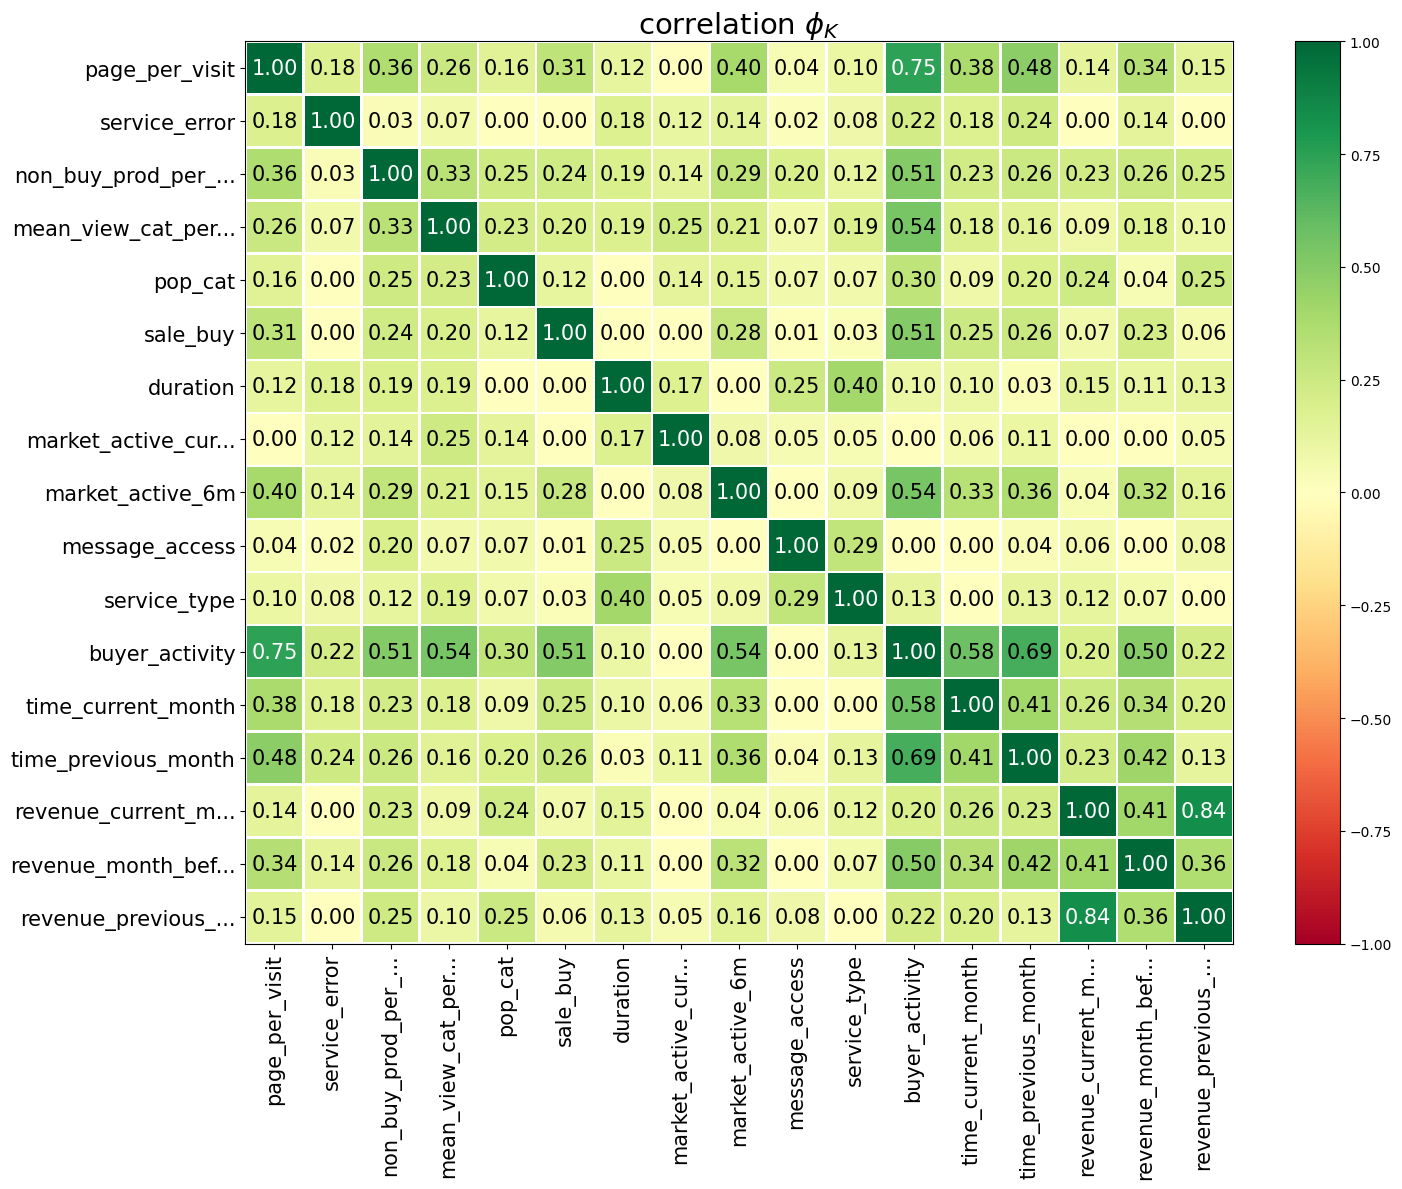

In [95]:
#sns.set(rc={"figure.figsize": (15, 8)})
#sns.heatmap(market_v2.corr(), annot=True, cmap='cividis');

# список интервальных признаков
interval_cols_v2 = ['revenue_previous_month', 
                 'revenue_month_before_last', 
                 'revenue_current_month', 
                 'time_previous_month', 
                 'time_current_month', 
                 'market_active_6m', 
                 'market_active_current_m', 
                 'duration', 
                 'sale_buy', 
                 'mean_view_cat_per_visit', 
                 'non_buy_prod_per_quarter', 
                 'service_error', 
                 'page_per_visit']

# вычисление коэффициентов корреляции phi
phik_overview_v2 = market_v2.phik_matrix(interval_cols=interval_cols_v2)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview_v2.values,
    x_labels=phik_overview_v2.columns,
    y_labels=phik_overview_v2.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Теперь линейная зависимость между признаками не прослеживается. От мультиколленеарности удалось избавиться. Можно отметить высокую зависимость между выручкой в текущем месяцу и выручкой в предыдущем = 0.84

## Шаг 6. Использование пайплайнов

### 6.1 Подготовка данных и пайплайнов

In [96]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [97]:
#делим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_v2.drop(['buyer_activity'], axis=1),
    market_v2['buyer_activity'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market['buyer_activity'])

In [98]:
#кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [99]:
#создание списков количественных и категориальных признаков

#категориальные
ohe_columns = ['message_access', 
               'pop_cat'] 

#количественные
num_columns = ['market_active_6m', 
           'duration', 
           'sale_buy',
           'page_per_visit', 
           'revenue_month_before_last',
           'revenue_previous_month',
           'revenue_current_month', 
           'time_previous_month', 
           'time_current_month', 
           'market_active_current_m',
           'mean_view_cat_per_visit',
           'non_buy_prod_per_quarter', 
           'service_error']

ord_columns = ['service_type']

In [100]:
#пайплайн для кодирования категориальных признаков

#SimpleImputer+OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ), 
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore') #sparse=False)
        )
    ]
)

#SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [101]:
#пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [102]:
#итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### 6.2 Обучение и поиск лучшей модели

#### Поиск модели без перебора гиперпараметров

In [103]:
#создаем словарь с параметрами для передачи GridSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE),
               KNeighborsClassifier(),
               SVC(random_state=RANDOM_STATE),
               LogisticRegression(random_state=RANDOM_STATE)]
}

In [104]:
#поиск оптимальной модели без перебора гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
)

#обучение модели на тренировочной выборке
grid.fit(X_train, y_train)

#вывод лучшей модели
print('Лучшая модель и её параметры:\n\n', grid.best_params_)

Лучшая модель и её параметры:

 {'models': SVC(random_state=42), 'preprocessor__num': StandardScaler()}


In [105]:
#вывод метрики лучшей модели
print('Метрика ROC-AUC для лучшей модели:\n', round(grid.best_score_, 4))

Метрика ROC-AUC для лучшей модели:
 0.9084


В качестве метрикы выбрана Roc-Auc, так как она оценивает работу модели более обобщённо, независимо от того, какой порог классификации выбран

#### Поиск модели с перебором гиперпараметров

In [106]:
#Создаем словарь с параметрами для передачи GridSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder и перебором гиперпараметров

param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__penalty':['l1','l2','None'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [107]:
#поиск оптимальной модели с перебором гиперпараметров
grid_gip = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)

#обучение модели на тренировочной выборке
grid_gip.fit(X_train, y_train)

#вывод лучшей модели
print('\nЛучшая модель и её параметры:\n\n', grid_gip.best_params_)  


Лучшая модель и её параметры:

 {'models': SVC(probability=True, random_state=42), 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}


C:\Users\evgen\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\evgen\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\evgen\anaconda3\envs\practicum\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\evgen\anaconda3\envs\practicum\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_es

In [108]:
#вывод метрики лучшей модели
print('Метрика ROC-AUC для лучшей модели:\n', round(grid_gip.best_score_, 4))

Метрика ROC-AUC для лучшей модели:
 0.9084


Лучше всех себя показала модель **метода опорных векторов** (SVC) **с ядром** (kernel) **радиальной базисной функции** (rbf) с метрикой roc_auc около 0.91

In [109]:
#проверяем на тестовой выборке
y_pred = grid_gip.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:, 1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.9124


На тестовой выборке метрика Roc_Auс показала такой же результат 0.91

## Шаг 7. Анализ важности признаков

### 7.1 Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.

C:\Users\evgen\AppData\Local\Temp\ipykernel_12780\3812506079.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=labels_1)


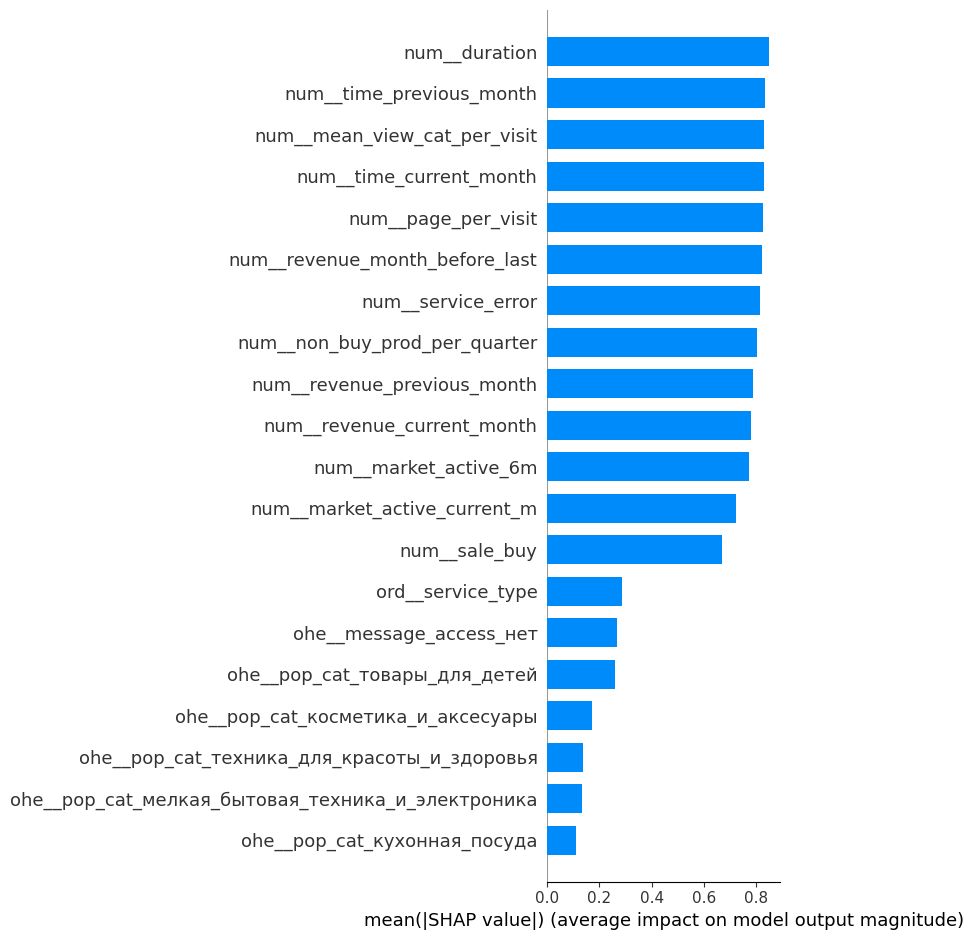

In [110]:
#поиск важных признаков
X_encoded_1 = grid_gip.best_estimator_['preprocessor'].fit_transform(X_train)

model_1 = grid_gip.best_estimator_['models'].fit(X_encoded_1, y_train)
explainer_1 = shap.PermutationExplainer(model_1, X_encoded_1)


labels_1 = grid_gip.best_estimator_[:-1].get_feature_names_out()

shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=labels_1)

## Шаг 8. Сегментация покупателей

### 8.1 Выполним сегментацию покупателей

In [111]:
#добавляем к данным покупателей их вероятности отношения к сегменту "Сниженый уровень активности"

X_test['probability'] = y_pred[:, 1]
data = X_test.sort_values(by='probability')
data.head()

,revenue_previous_month,revenue_month_before_last,revenue_current_month,time_previous_month,time_current_month,service_type,message_access,market_active_6m,market_active_current_m,duration,sale_buy,pop_cat,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit,probability
485,4893.0,5268.0,4698.0,15,18,премиум,да,4.9,3,888,0.14,техника_для_красоты_и_здоровья,3,1,6,9,0.016289
695,5696.5,5194.0,6262.0,16,18,премиум,да,3.9,4,572,0.14,мелкая_бытовая_техника_и_электроника,4,2,2,6,0.020207
1113,5505.5,5180.0,5917.6,18,15,стандарт,да,4.9,4,739,0.17,мелкая_бытовая_техника_и_электроника,5,1,4,4,0.021103
453,4126.0,4691.0,4746.1,12,16,стандарт,нет,4.1,4,808,0.15,мелкая_бытовая_техника_и_электроника,4,2,3,13,0.021542
473,5063.5,5053.0,5202.6,17,15,премиум,да,4.3,4,951,0.20,домашний_текстиль,3,3,4,10,0.022082


In [112]:
num_data = ['market_active_6m', 
            'market_active_current_m', 
            'duration', 
            'sale_buy', 
            'mean_view_cat_per_visit', 
            'non_buy_prod_per_quarter', 
            'service_error', 
            'page_per_visit', 
            'revenue_month_before_last', 
            'time_previous_month', 
            'time_current_month', 
            'revenue_current_month',
            'revenue_previous_month'          
           ]

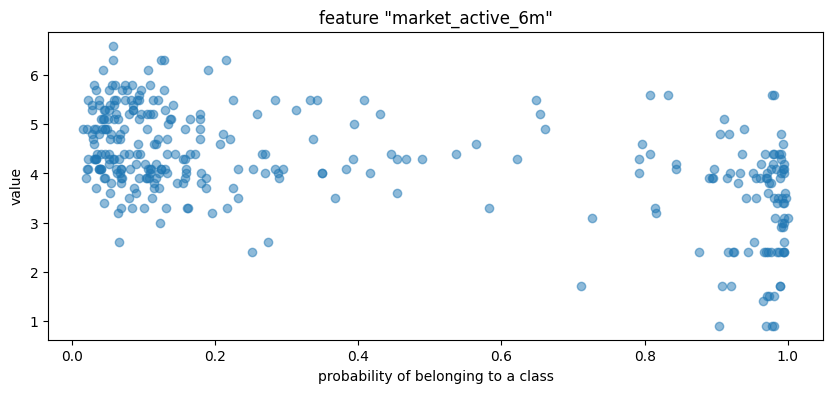

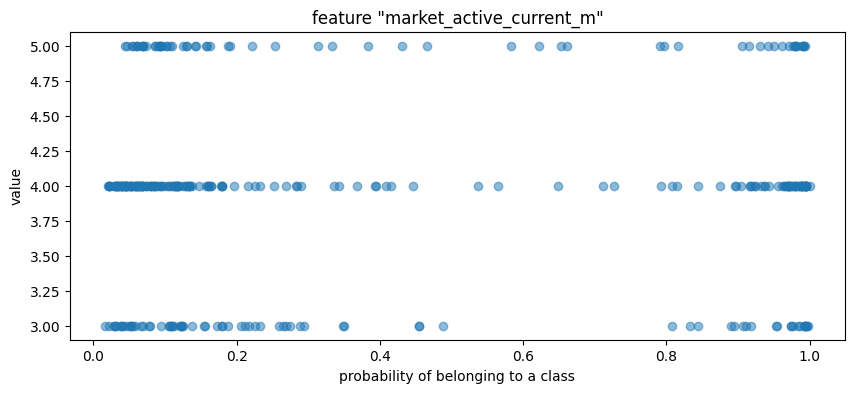

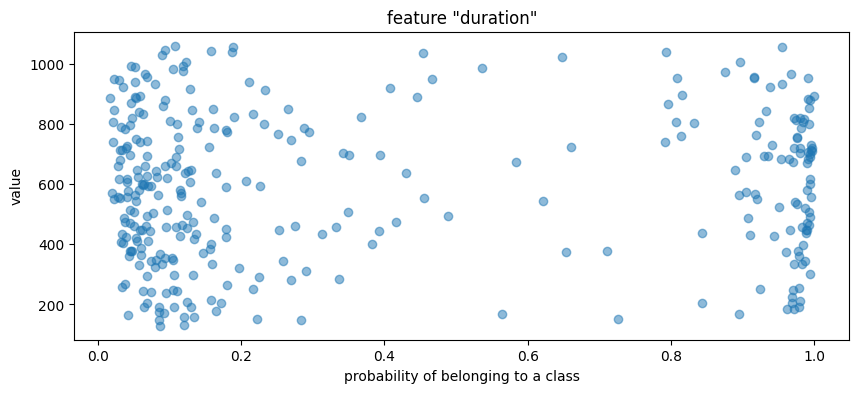

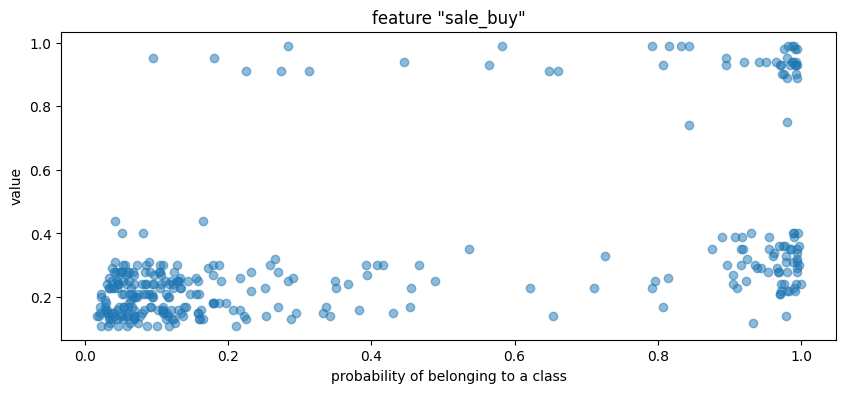

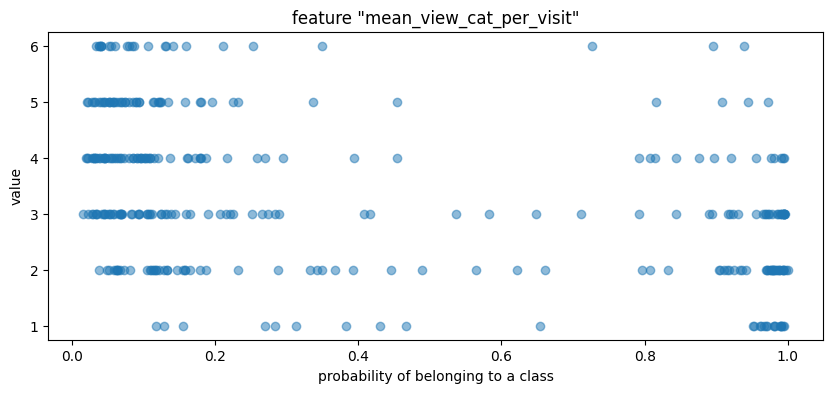

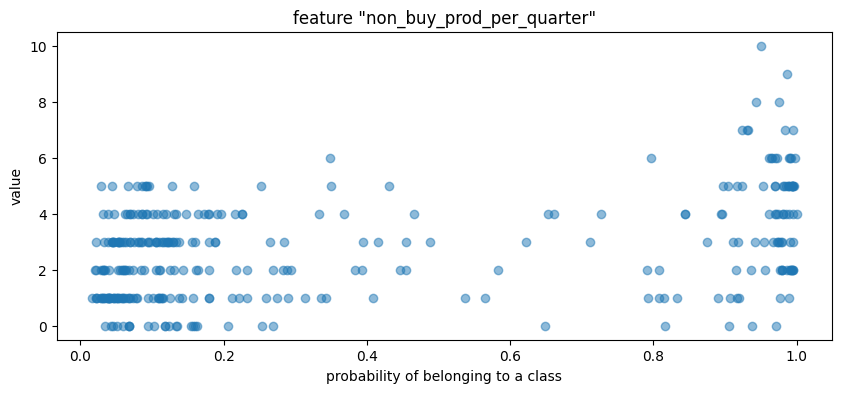

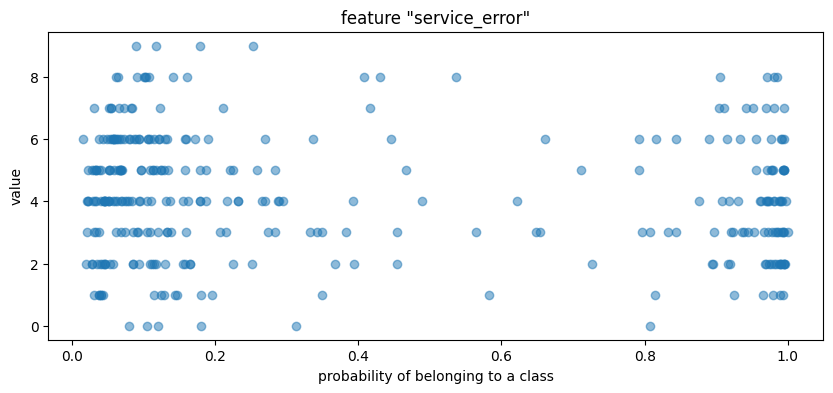

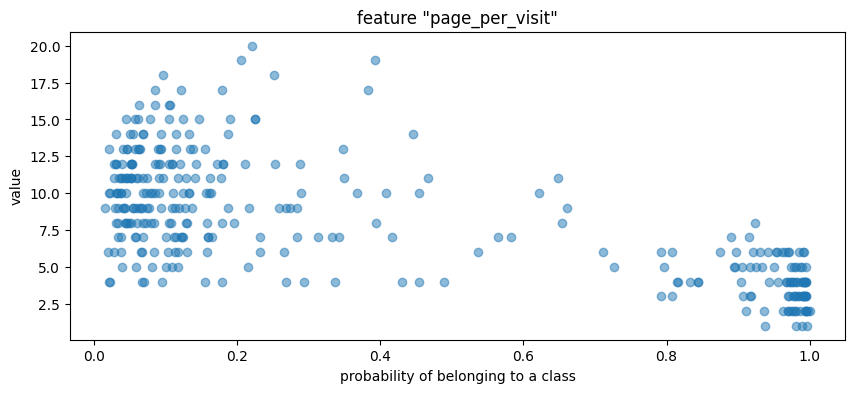

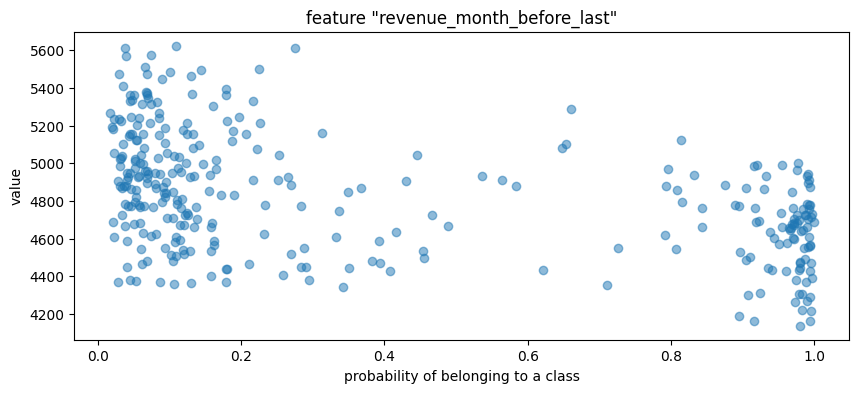

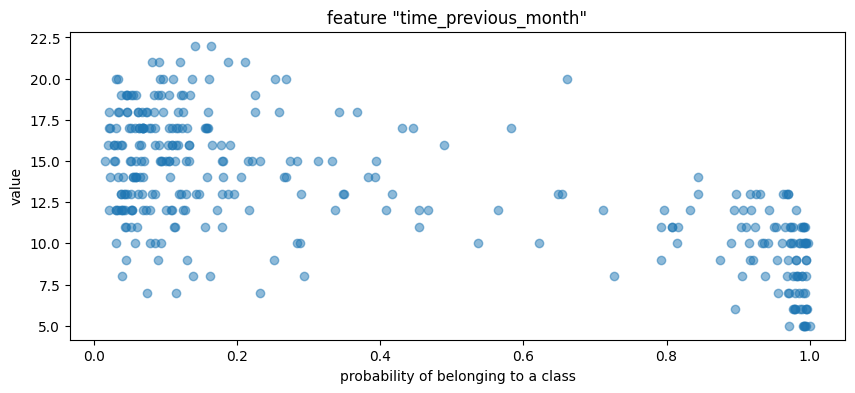

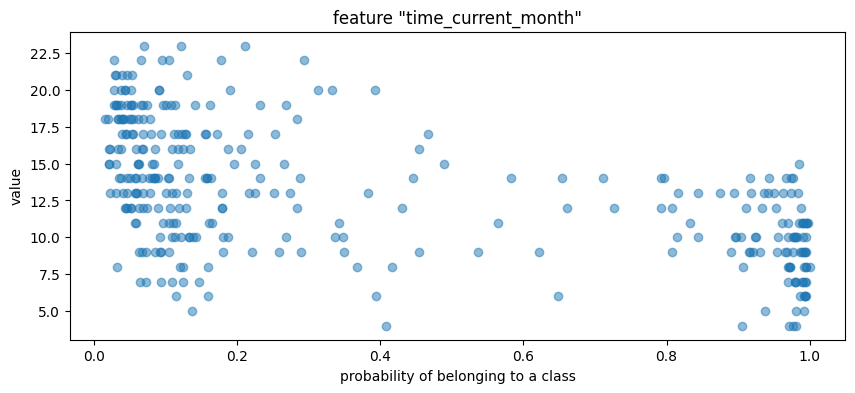

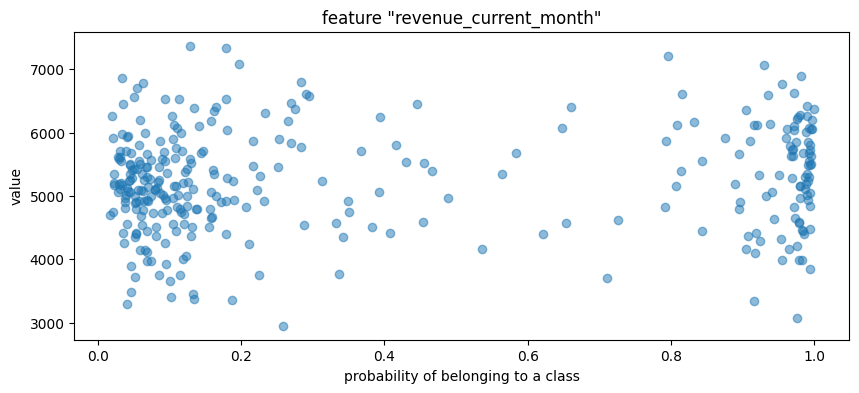

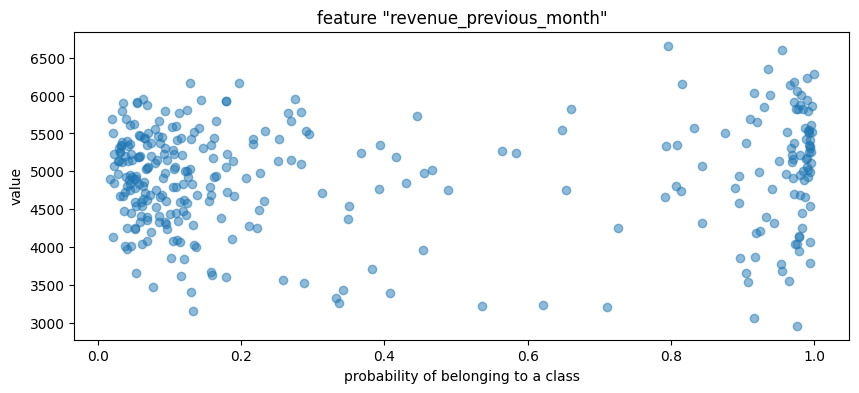

In [113]:
#построим scatter plot для распределения числовых признаков в зависимости от вероятности принадлежности к сегменту

for name in num_data:
    plt.figure(figsize=(10, 4))
    plt.title(f'feature "{name}"')
    plt.xlabel('probability of belonging to a class')
    plt.ylabel(f'value')
    plt.scatter(x=data['probability'], 
                y=data[name],
                alpha=0.5
               )

На основании графиков можно выделить следующие пороги значений признака для разделения покупателей на сегменты. В частности, покупатели со сниженной активностью имеют значения признака:
- **market_active_6m** (среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев) - **менее 3**;
- **sale_buy** (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев) - **выше 0.6**;
- **mean_view_cat_per_visit** (оказывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца) - **менее 3**;
- **non_buy_prod_per_quarter** (общее число неоплаченных товаров в корзине за последние 3 месяца) - **более 5**;
- **page_per_visit** (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца) - **менее 7**;
- **revenue_month_before_last** (сумма выручки за препредыдущий месяц) - **ниже 5000**;
- **time_previous_month** (начение времени, проведённого на сайте в предыдущем месяце, в минутах) - **ниже 14**;
- **time_current_month** (начение времени, проведённого на сайте в текущем месяце, в минутах) - **ниже 14**. 

В остальных признаках сложно выделить пороги. 

### 8.2 Выберем группу покупателей и предложим, как увеличить её покупательскую активность

In [114]:
df = data.query('revenue_month_before_last < 5000')

In [115]:
#списки количественных и категориальных признаков
num_df = ['market_active_6m',          
          'market_active_current_m', 
          'duration',
          'mean_view_cat_per_visit',
          'sale_buy', 
          'non_buy_prod_per_quarter', 
          'service_error', 
          'page_per_visit', 
          'time_previous_month', 
          'time_current_month', 
          'revenue_month_before_last',
          'revenue_previous_month',
          'revenue_current_month']

cat_df = ['service_type', 'message_access', 'pop_cat']

In [116]:
def hist_box(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.title(column)
    sns.histplot(data[column])
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])

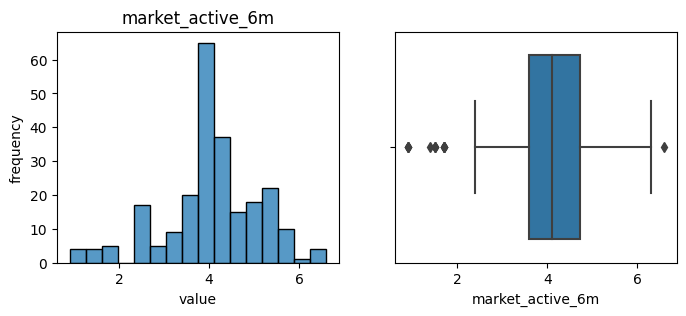

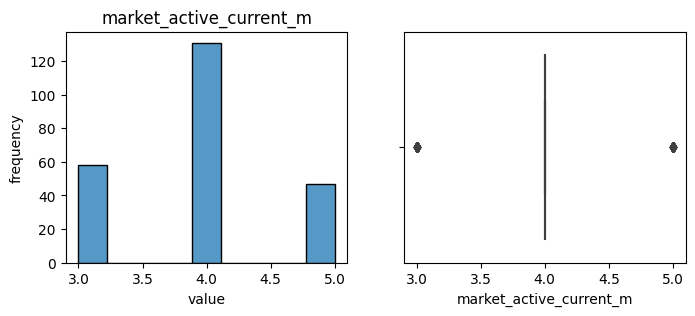

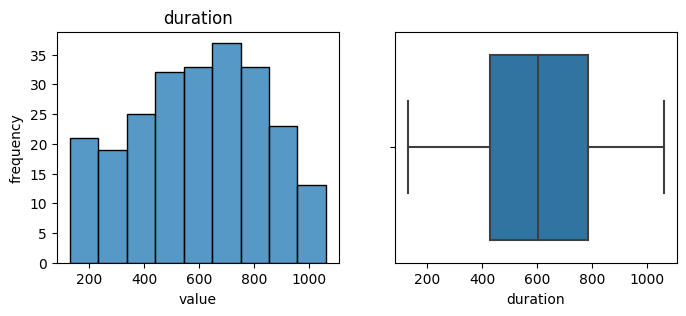

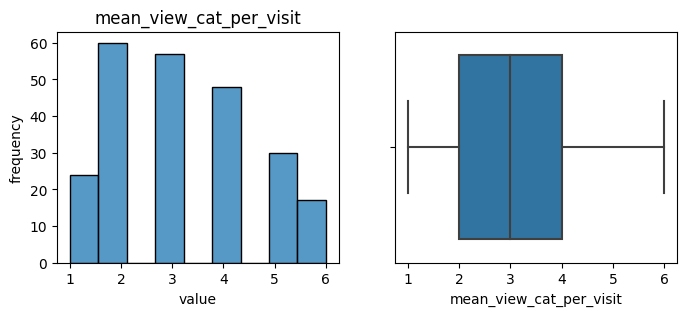

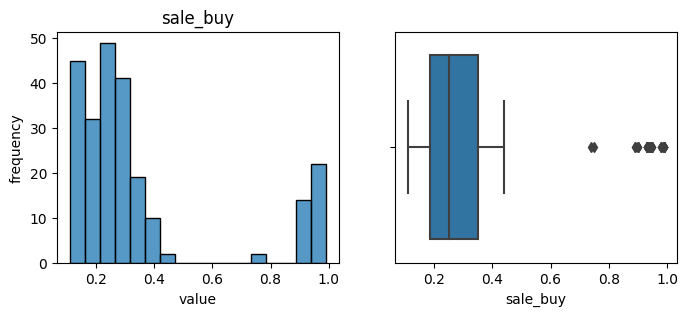

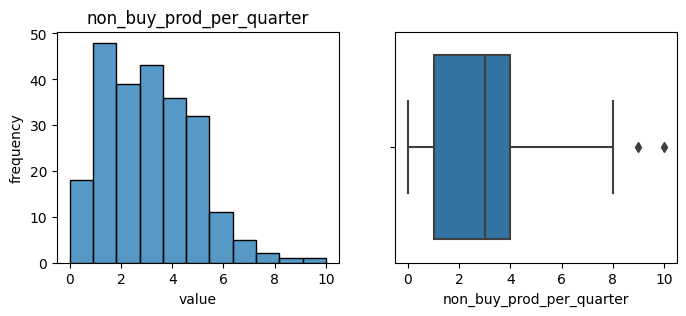

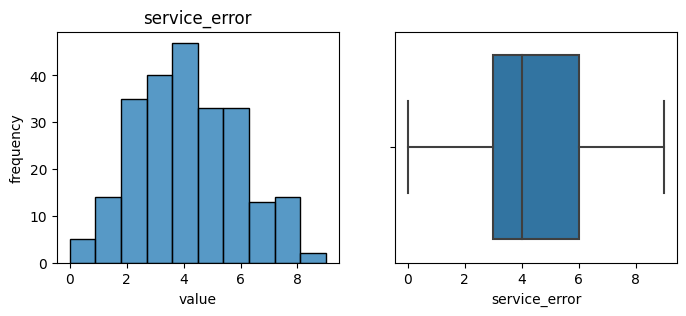

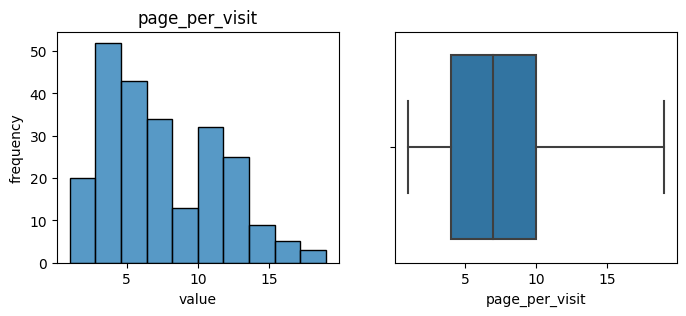

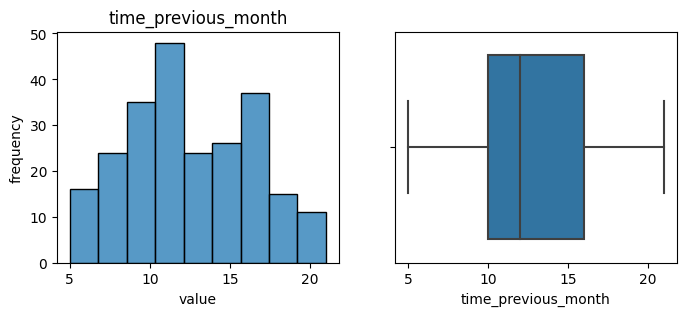

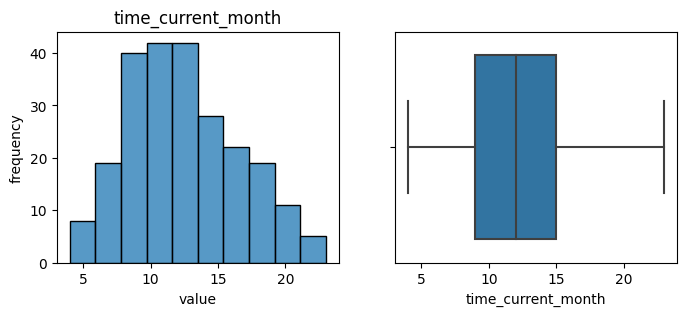

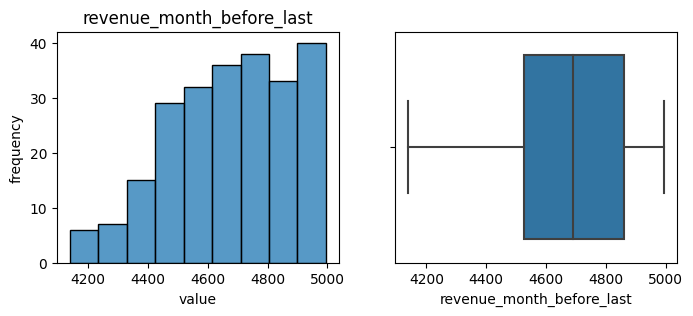

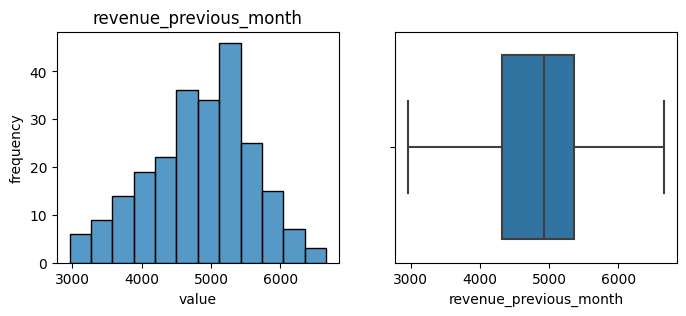

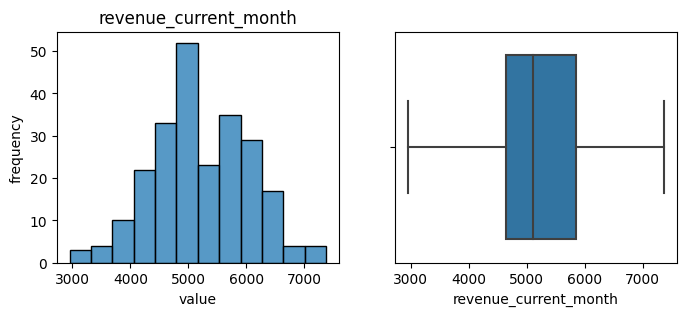

In [117]:
#построим распределения количественных признаков
for name in num_df:
    hist_box(df, name)

In [118]:
#создание функции для построения круговой диаграммы для категориальных признаков

def pie_graph(dataset, column, name, n, i):
    plt.subplot(1, n, i)
    plt.title(column)
    plt.pie(x=dataset.groupby(column)[name].count(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=dataset.groupby(column)[name].count().index, 
            colors=sns.color_palette('BuPu_r'))

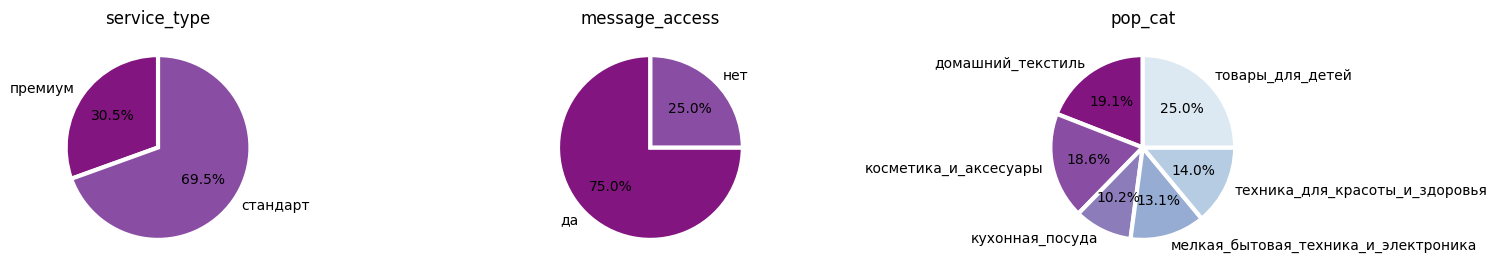

In [119]:
#построение распределений категориальных признаков

i = 1
plt.figure(figsize=(18,3))
for name in cat_df:
    pie_graph(df, name, 'market_active_current_m',len(cat_df), i)
    i += 1

Данный сегмент покупателей в основном покупает товары для детей и домашний текстиль. Также большинство таких покупателей не покупает по акциям, хотя им приходят рассылка различных предложений.

Возможно данной категории пользователей стоит разослать акции на товары для детей.

In [120]:
market = market.merge(profit, 
                      on='id', 
                      how='left',)
market.head()

,id,revenue_previous_month,revenue_month_before_last,revenue_current_month,time_previous_month,time_current_month,buyer_activity,service_type,message_access,market_active_6m,market_active_current_m,duration,sale_buy,pop_cat,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit,profit
0,215349,5216.0,4472.0,4971.6,12,10,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4.16
1,215350,5457.5,4826.0,5058.4,8,13,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,3.13
2,215351,6158.0,4793.0,6610.4,11,13,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4.87
3,215352,5807.5,4594.0,5872.5,8,11,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4.21
4,215353,4738.5,5124.0,5388.5,10,10,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,3.95


In [121]:
def hist_box_graph_1(dataset, column):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=dataset, x=column, hue='buyer_activity', palette='BuPu')
    plt.xlabel(column)
    plt.ylabel('frequency')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='buyer_activity', y=column, data=dataset, palette='BuPu');
    plt.ylabel(column)

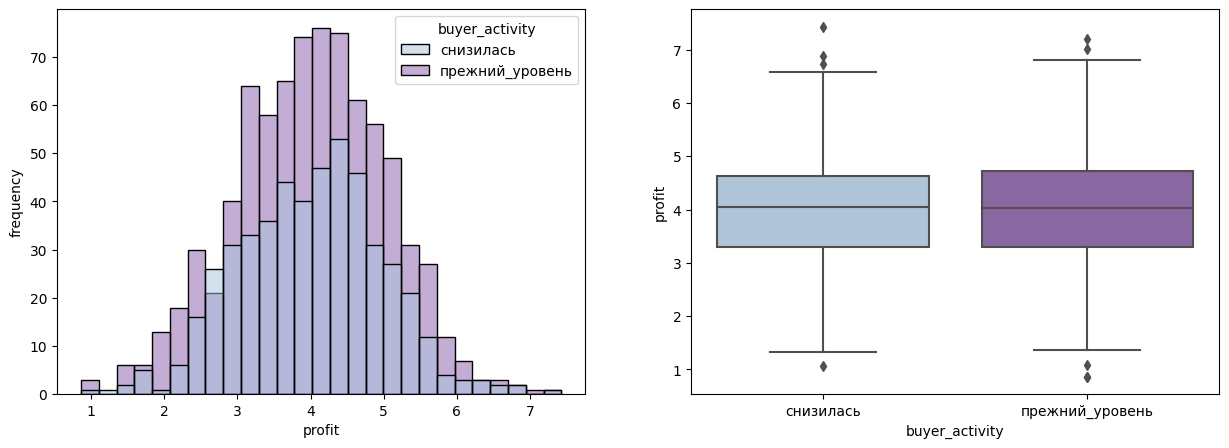

In [122]:
hist_box_graph_1(market, 'profit')

По прибыли никакой разницы нет между теми у кого снизилась активность и у кого нет.

Выделить сегмент по категории товаров и проведем исследовательский анализ

In [123]:
kids = market.query('pop_cat == "товары_для_детей"')
kids.head()

,id,revenue_previous_month,revenue_month_before_last,revenue_current_month,time_previous_month,time_current_month,buyer_activity,service_type,message_access,market_active_6m,market_active_current_m,duration,sale_buy,pop_cat,mean_view_cat_per_visit,non_buy_prod_per_quarter,service_error,page_per_visit,profit
0,215349,5216.0,4472.0,4971.6,12,10,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4.16
2,215351,6158.0,4793.0,6610.4,11,13,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4.87
3,215352,5807.5,4594.0,5872.5,8,11,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4.21
6,215355,3263.0,4749.0,3772.6,12,10,снизилась,стандарт,нет,4.7,4,284,0.17,товары_для_детей,5,1,6,4,5.26
12,215363,6010.0,4633.0,6128.3,8,5,снизилась,стандарт,нет,4.9,4,923,0.29,товары_для_детей,6,0,3,1,1.83


In [124]:
num_df = ['mean_view_cat_per_visit',
          'sale_buy',
          'non_buy_prod_per_quarter',
          'page_per_visit',
          'time_previous_month', 
          'time_current_month',
          'revenue_month_before_last',
          'revenue_current_month',
          'revenue_previous_month',
          'profit']

cat_df = ['service_type', 'message_access', 'pop_cat']

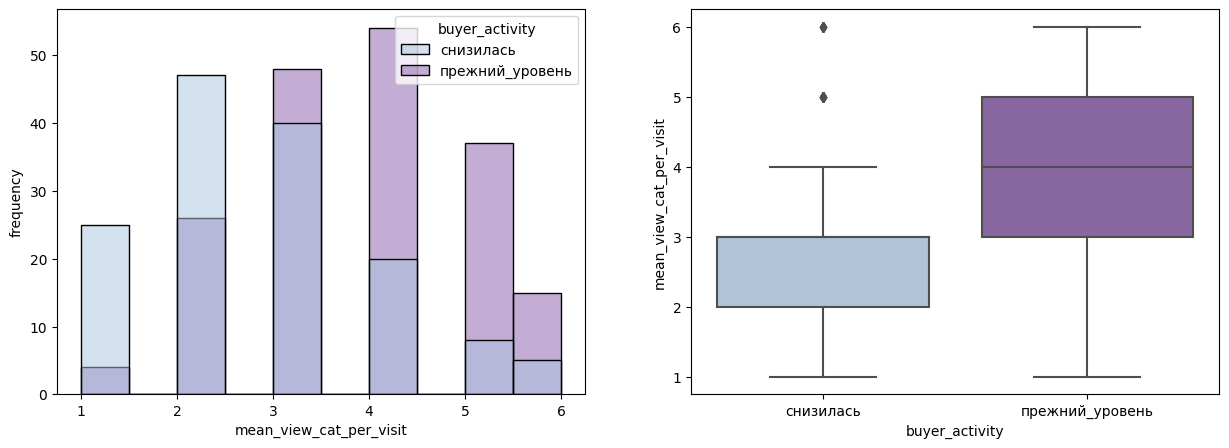

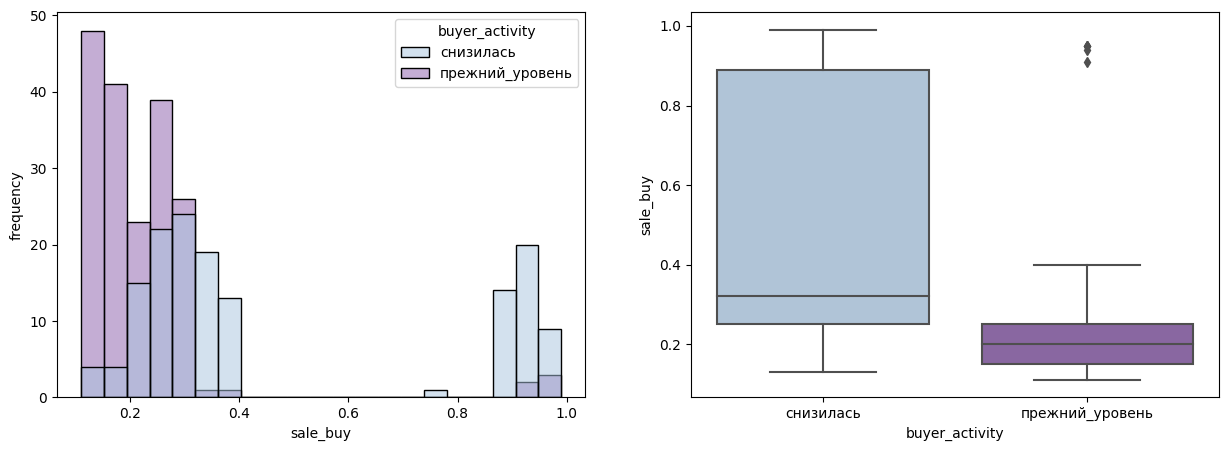

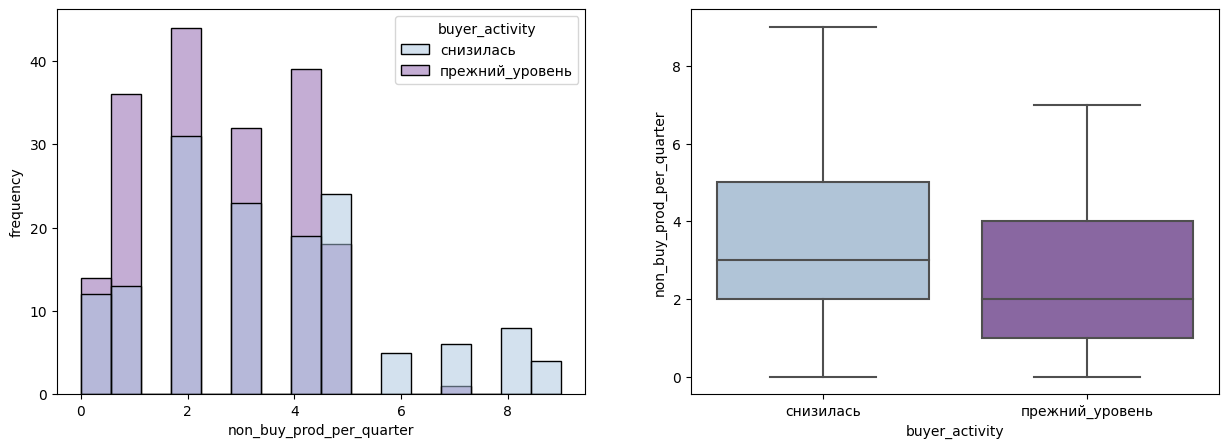

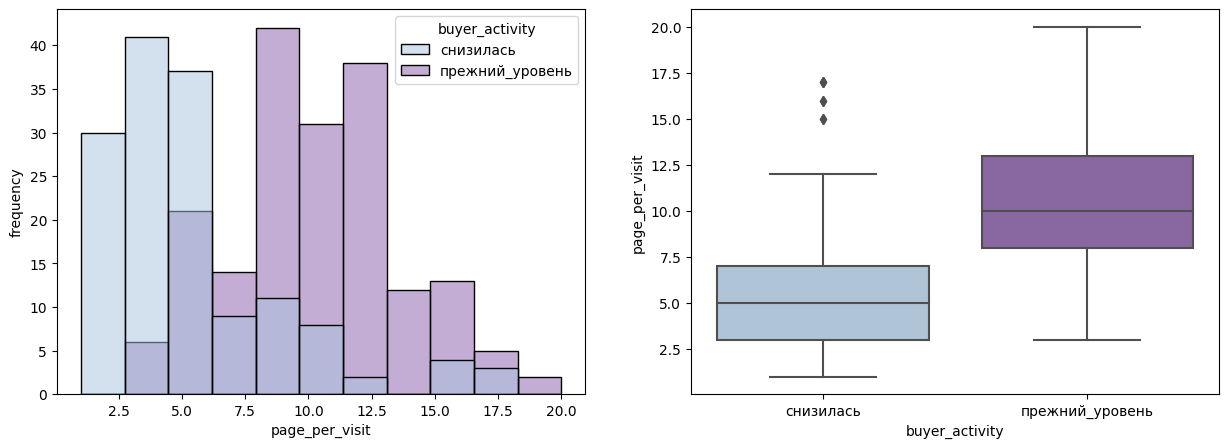

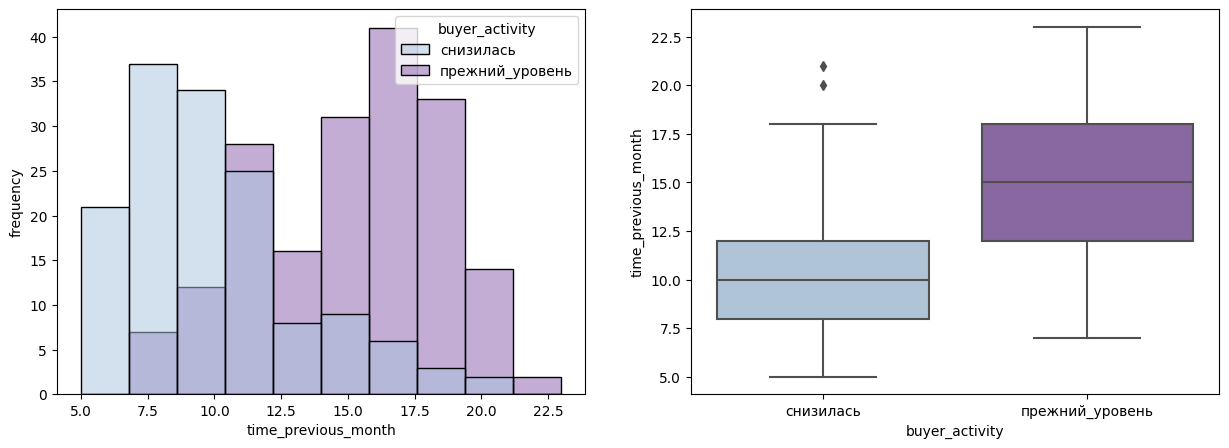

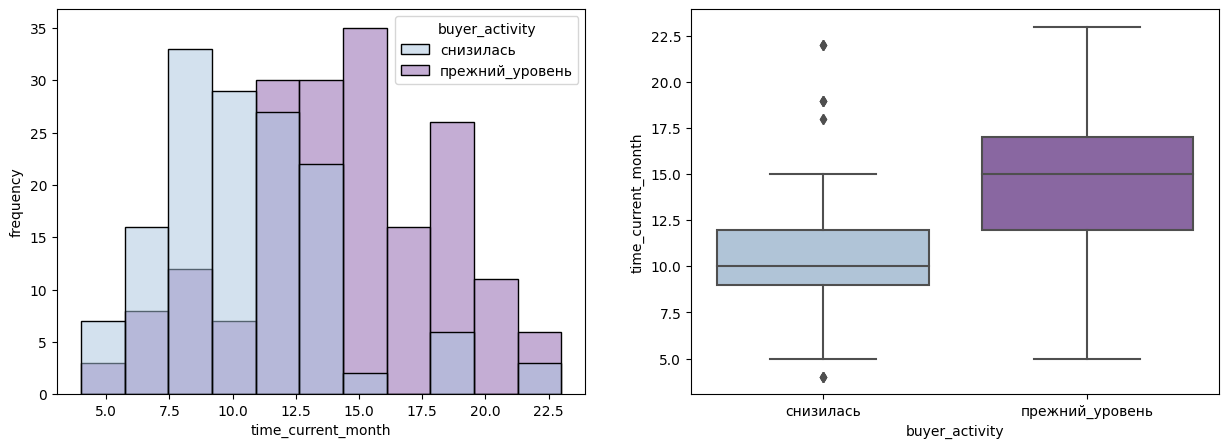

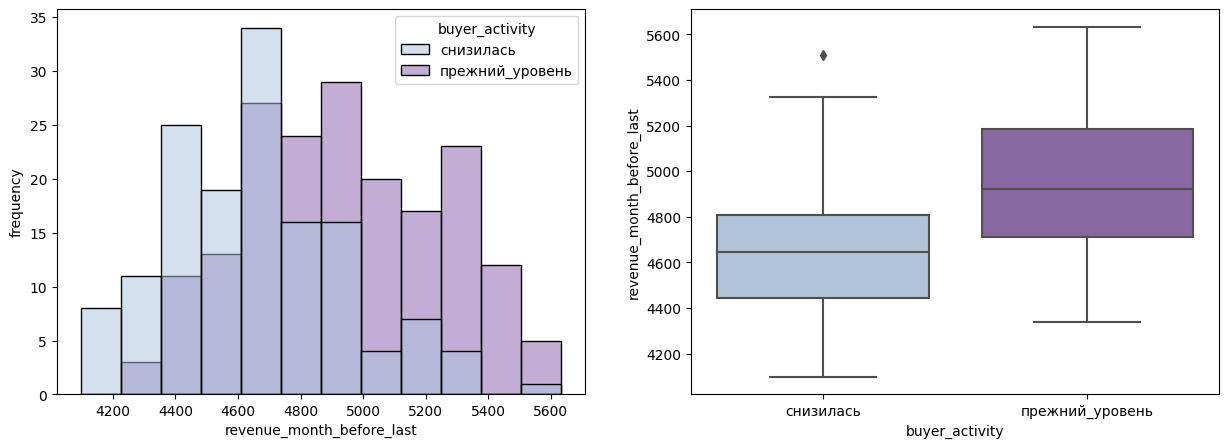

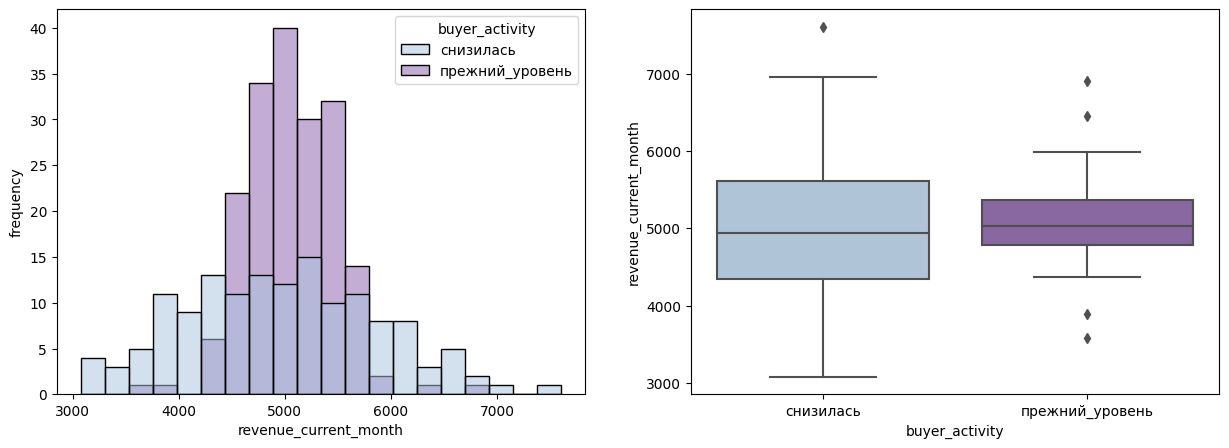

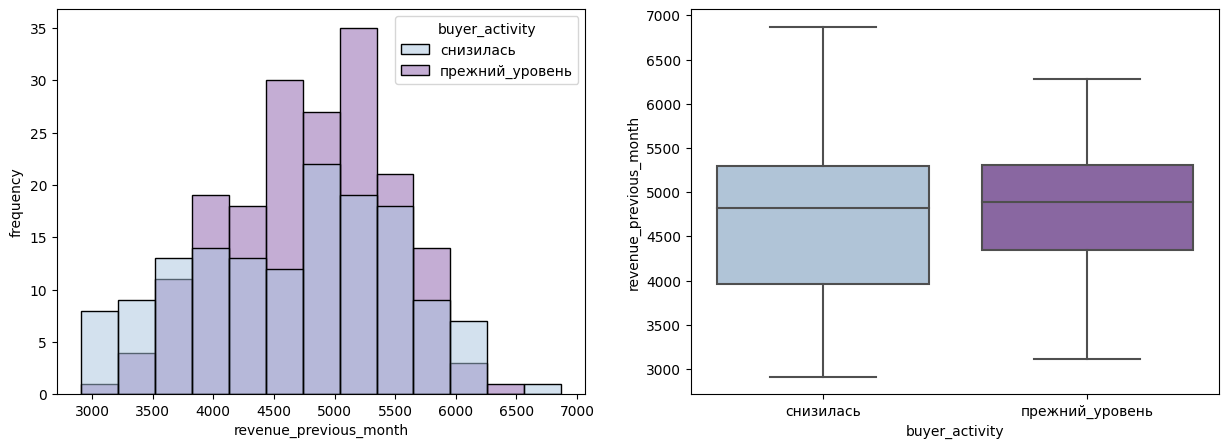

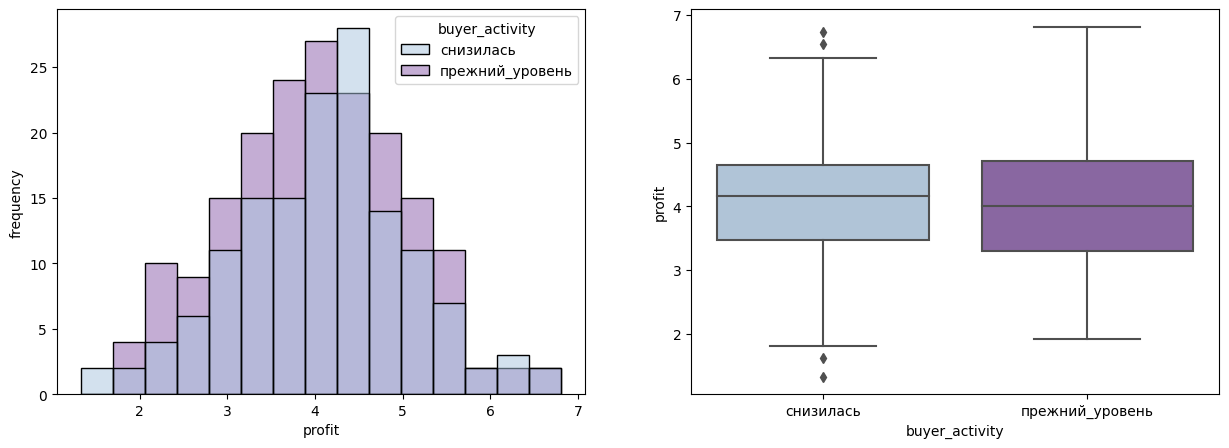

In [125]:
for name in num_df:
    hist_box_graph_1(kids, name)

Покупатели, у которых категория "товары_для_детей" и у которых снизилась покупательская активность, в основном покупают по акции, практически не рассматривают другие категори за визит, просматривают мало страниц и проводят меньше времени на сайте, чем покупатели, у которых активность осталась на прежнем уровне.

Взможно есть необхожимость проведения ауции для рассматриваемой категории товаров

## Шаг 9. Общий вывод

Перед нами стояла задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

* Исходные данные у нас были в виде четырех датасэтов. В результате прдобработки мы избавились от пропусков и дубликатов, привели строчные значения к одному регистру и исправили неверные форматы в данных.

* Провели исследовательский анализ данных. Избавились от вылетов и аномалий, а так же исключили 3х клиентов, которые не подходили под условие совершения покупок последние 3 месяца. 

* Объединили таблицы и провели корреляционный анализ признаков, по результатом которого избавились от мультиколленеарности

* Выпонили подготовку пайплайнов и выполнили поиск лучшей модели с перебором гиперпараметров и без. Лучшей моделью оказалась SVC - "метод опорных векторов" c праметром 'kernel = rbf' и  значением метрики roc_auc=0.91.

* Выполнили анализ важности принаков. Наименее важными оказались популряные категориии товаров у пользователей, а так же разрешение на отправку сообщений с акциями. Наиболее важным признаком оказалось duration (время прошедшее с момента регистрации), time_previous_month (время проведенное на сайте в предыдущем месяце), mean_view_cat_per_visit (средний просмотр категория за визит).

* Выполнили сегментацию покупателей и выяснили, что покупатели, у которых категория "товары_для_детей" и у которых снизилась покупательская активность, в основном покупают по акции, практически не рассматривают другие категори за визит, просматривают мало страниц и проводят меньше времени на сайте, чем покупатели, у которых активность осталась на прежнем уровне. Одним из предложений для данного сегмента - это устроить акцию.